### TODO Recording:

- Start with the notebook open
- Copy the code one cell at a time

In [ ]:
%pip install torch matplotlib numpy pandas pytorch_lightning mlflow pyngrok

In [3]:
# Use Apple GPU
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple GPU with Metal backend.")
else:
    device = torch.device("cpu")
    print("Using CPU.")

Using Apple GPU with Metal backend.


In [ ]:
# Run this in Terimnal
# !mlflow server --host 127.0.0.1 --port 8080

[2025-07-16 16:58:39 -0400] [15804] [INFO] Starting gunicorn 23.0.0
[2025-07-16 16:58:39 -0400] [15804] [INFO] Listening at: http://127.0.0.1:8080 (15804)
[2025-07-16 16:58:39 -0400] [15804] [INFO] Using worker: sync
[2025-07-16 16:58:39 -0400] [15805] [INFO] Booting worker with pid: 15805
[2025-07-16 16:58:40 -0400] [15806] [INFO] Booting worker with pid: 15806
[2025-07-16 16:58:40 -0400] [15807] [INFO] Booting worker with pid: 15807
[2025-07-16 16:58:40 -0400] [15808] [INFO] Booting worker with pid: 15808
^C
[2025-07-16 16:58:57 -0400] [15804] [INFO] Handling signal: int
[2025-07-16 16:58:58 -0400] [15805] [INFO] Worker exiting (pid: 15805)
[2025-07-16 16:58:58 -0400] [15807] [INFO] Worker exiting (pid: 15807)
[2025-07-16 16:58:58 -0400] [15806] [INFO] Worker exiting (pid: 15806)
[2025-07-16 16:58:58 -0400] [15808] [INFO] Worker exiting (pid: 15808)


In [22]:
import mlflow
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

In [ ]:
from IPython import get_ipython
# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &") # run tracking UI in the background


# create remote tunnel using ngrok.com to allow local port access
from pyngrok import ngrok

# Terminate open tunnels if they exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "2zxlxQ9Wu8RL4vYWWFUojYXIvJG_PZaS1RVtGRqVJnm4FC8e"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr = "5000", proto = "http", bind_tls = True)

print("MLflow Tracking UI:", ngrok_tunnel.public_url)

### TODO Recording:

- Go to the MLflow UI and show that it is empty

In [12]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

In [13]:
# from google.colab import drive
# drive.mount('/content/drive')
DATA_PATH = "/Users/tawate/Documents/DeepLearning_AI_Courses/LinkedIn_Learning_Full_Stack_DL_Python/datasets/"

In [14]:
emnist_train_data  = pd.read_csv(DATA_PATH + "emnist-letters-train.csv")

emnist_test_data = pd.read_csv(DATA_PATH + "emnist-letters-test.csv")

In [15]:
class EMNISTDataset(Dataset):
    def __init__(self, dataframe):

        self.images = torch.tensor(dataframe.iloc[:, 1:].values, dtype= torch.float32)

        self.labels = torch.tensor(dataframe.iloc[:, 0].values, dtype = torch.float32)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        images = self.images[idx]

        images = images / 255.0
        labels = self.labels[idx]

        return images, labels

In [16]:
emnist_test_data = emnist_test_data.sample(frac = 1)

In [17]:
train_dataset = EMNISTDataset(emnist_train_data)

test_dataset = EMNISTDataset(emnist_test_data )

In [18]:
from torch.utils.data import random_split

val_percent = 0.1
val_len = int(val_percent * len(train_dataset))

train_ds, val_ds = random_split(train_dataset, [len(train_dataset) - val_len, val_len])

In [34]:
batch_size = 64

train_dataloader = DataLoader(train_ds, batch_size, shuffle = True, drop_last = True, num_workers=0)

val_dataloader = DataLoader(val_ds, batch_size, num_workers=0)

test_dataloader = DataLoader(test_dataset, batch_size, num_workers=0)

len(train_dataloader), len(val_dataloader), len(test_dataloader)

(1248, 139, 232)

All libraries for model training are imported

In [35]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl

from torchmetrics.functional import accuracy

In [ ]:
import mlflow

experiment_id = mlflow.create_experiment(name = "emnist_letters_prediction_using_cnn")

mlflow.set_experiment(experiment_name = "emnist_letters_prediction_using_cnn")

Defining Lightning Module for Letter classification. Model is CNN and metrics are logged using log method of lightning

In [36]:
class EmnistModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.criterion = nn.CrossEntropyLoss()

        self.network = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 64 * 14 * 14

            nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #256 * 7 * 7

            nn.Flatten(),
            nn.Linear(256*7*7, 32),
            nn.ReLU(),

            nn.Linear(32, 64),
            nn.ReLU(),

            nn.Linear(64, 26)
        )

    def forward(self, xb):
        return self.network(xb.reshape(-1, 1, 28, 28))

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr = 0.0001)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y -= 1

        y_hat = self(x)
        loss = self.criterion(y_hat, y.long())
        pred = y_hat.argmax(dim = 1)

        acc = accuracy(pred, y, task = "multiclass", num_classes = 26)

        self.log("train_loss", loss, on_epoch = True, prog_bar = True)
        self.log("train_acc", acc, on_epoch = True, prog_bar = True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y -= 1

        y_hat = self(x)
        loss = self.criterion(y_hat, y.long())
        pred = y_hat.argmax(dim = 1)

        acc = accuracy(pred, y, task = "multiclass", num_classes = 26)

        self.log("valid_loss", loss, on_epoch = True, prog_bar = True)
        self.log("valid_acc", acc, on_epoch = True, prog_bar = True)

        return acc

    def test_step(self, batch, batch_idx):
        x, y = batch
        y -= 1

        y_hat = self(x)
        loss = self.criterion(y_hat, y.long())
        pred = y_hat.argmax(dim = 1)

        acc = accuracy(pred, y, task = "multiclass", num_classes = 26)

        self.log("test_loss", loss, logger = True)
        self.log("test_acc", acc, logger = True)

        return acc


    def predict_step(self, batch, batch_idx, dataloader_idx = 0):
        x, y = batch

        return self(x)

Model Training is done  with Trainer and All parameters are autologged using mlflow autologging and Trained Model is logged separately with defined Signature with input and output schema. Model metrics are also separately logged using CSV logger. Training is done for 10 epochs and then Model is tested on Test dataloader

In [37]:
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import ColSpec, Schema, TensorSpec
from pytorch_lightning.loggers import CSVLogger

emnist_model = EmnistModel()

logger = CSVLogger("logs", name = "emnist_letters_classification")

trainer = pl.Trainer(max_epochs = 10, logger = logger)

mlflow.pytorch.autolog(log_models = False)

with mlflow.start_run() as run:

    trainer.fit(emnist_model, train_dataloader, val_dataloader)
    trainer.test(dataloaders = test_dataloader)

    input_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 1, 28, 28))])
    output_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 26))])
    signature = ModelSignature(inputs = input_schema, outputs = output_schema)

    mlflow.pytorch.log_model(emnist_model, "emnist-letters-classifier-cnn-model", signature = signature)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | criterion | CrossEntropyLoss | 0      | train
1 | network   | Sequential       | 793 K  | train
-------------------------------------------------------
793 K     Trainable params
0         Non-trainable params
793 K     Total params
3.172     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/tawate/Documents/DeepLearning_AI_Courses/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/Users/tawate/Documents/DeepLearning_AI_Courses/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1248/1248 [00:50<00:00, 24.83it/s, v_num=4, train_loss_step=0.426, train_acc_step=0.844, valid_loss=0.493, valid_acc=0.844, train_loss_epoch=1.130, train_acc_epoch=0.661]

2025/07/16 17:09:18 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 1: 100%|██████████| 1248/1248 [00:48<00:00, 25.95it/s, v_num=4, train_loss_step=0.261, train_acc_step=0.906, valid_loss=0.373, valid_acc=0.878, train_loss_epoch=0.435, train_acc_epoch=0.866]

2025/07/16 17:10:06 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 2: 100%|██████████| 1248/1248 [00:47<00:00, 26.35it/s, v_num=4, train_loss_step=0.589, train_acc_step=0.859, valid_loss=0.312, valid_acc=0.899, train_loss_epoch=0.343, train_acc_epoch=0.891]

2025/07/16 17:10:53 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 3: 100%|██████████| 1248/1248 [00:47<00:00, 26.37it/s, v_num=4, train_loss_step=0.270, train_acc_step=0.859, valid_loss=0.290, valid_acc=0.906, train_loss_epoch=0.291, train_acc_epoch=0.907] 

2025/07/16 17:11:41 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 4: 100%|██████████| 1248/1248 [00:48<00:00, 25.48it/s, v_num=4, train_loss_step=0.385, train_acc_step=0.875, valid_loss=0.267, valid_acc=0.909, train_loss_epoch=0.256, train_acc_epoch=0.916] 

2025/07/16 17:12:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 5: 100%|██████████| 1248/1248 [00:47<00:00, 26.10it/s, v_num=4, train_loss_step=0.418, train_acc_step=0.906, valid_loss=0.259, valid_acc=0.915, train_loss_epoch=0.229, train_acc_epoch=0.924] 

2025/07/16 17:13:18 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 6: 100%|██████████| 1248/1248 [00:49<00:00, 25.36it/s, v_num=4, train_loss_step=0.116, train_acc_step=0.953, valid_loss=0.236, valid_acc=0.922, train_loss_epoch=0.208, train_acc_epoch=0.931] 

2025/07/16 17:14:07 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 7: 100%|██████████| 1248/1248 [00:49<00:00, 25.14it/s, v_num=4, train_loss_step=0.105, train_acc_step=0.953, valid_loss=0.232, valid_acc=0.925, train_loss_epoch=0.191, train_acc_epoch=0.936] 

2025/07/16 17:14:57 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 8: 100%|██████████| 1248/1248 [00:49<00:00, 25.20it/s, v_num=4, train_loss_step=0.0543, train_acc_step=1.000, valid_loss=0.223, valid_acc=0.924, train_loss_epoch=0.176, train_acc_epoch=0.939]

2025/07/16 17:15:46 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


Epoch 9: 100%|██████████| 1248/1248 [00:49<00:00, 25.29it/s, v_num=4, train_loss_step=0.097, train_acc_step=0.984, valid_loss=0.218, valid_acc=0.925, train_loss_epoch=0.164, train_acc_epoch=0.943] 

2025/07/16 17:16:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1248/1248 [00:49<00:00, 25.25it/s, v_num=4, train_loss_step=0.097, train_acc_step=0.984, valid_loss=0.218, valid_acc=0.925, train_loss_epoch=0.164, train_acc_epoch=0.943]


/Users/tawate/Documents/DeepLearning_AI_Courses/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at logs/emnist_letters_classification/version_4/checkpoints/epoch=9-step=12480.ckpt
Loaded model weights from the checkpoint at logs/emnist_letters_classification/version_4/checkpoints/epoch=9-step=12480.ckpt
/Users/tawate/Documents/DeepLearning_AI_Courses/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to impro

Testing DataLoader 0: 100%|██████████| 232/232 [00:06<00:00, 33.22it/s]

2025/07/16 17:16:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9154672622680664
        test_loss           0.25361403822898865
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
🏃 View run adventurous-sow-834 at: http://127.0.0.1:8080/#/experiments/276748476805243944/runs/22ae1ed50d724270b87bcc67c4b1fcf6
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/276748476805243944


### TODO Recording

- Go to the MLflow UI
- Show the new run
- IMPORTANT: Show the charts in the chart tab
- Click through to the run
- Show everything logged
- Click on each artifact under MLmodel

Logged metrics dataframe is obtained

In [38]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

metrics

epoch   step  test_acc  test_loss  train_acc_epoch  train_acc_step  \
0        0     49       NaN        NaN              NaN        0.171875   
1        0     99       NaN        NaN              NaN        0.218750   
2        0    149       NaN        NaN              NaN        0.359375   
3        0    199       NaN        NaN              NaN        0.578125   
4        0    249       NaN        NaN              NaN        0.609375   
..     ...    ...       ...        ...              ...             ...   
265      9  12399       NaN        NaN              NaN        0.937500   
266      9  12449       NaN        NaN              NaN        0.890625   
267      9  12479       NaN        NaN              NaN             NaN   
268      9  12479       NaN        NaN         0.943347             NaN   
269     10  12480  0.915467   0.253614              NaN             NaN   

     train_loss_epoch  train_loss_step  valid_acc  valid_loss  
0                 NaN         3.202451        NaN         NaN  
1                 NaN         2.715237        NaN         NaN  
2                 NaN         2.097419        NaN         NaN  
3                 NaN         1.609915        NaN         NaN  
4                 NaN         1.539820        NaN         NaN  
..                ...              ...        ...         ...  
265               NaN         0.096266        NaN         NaN  
266               NaN         0.430716        NaN         NaN  
267               NaN              NaN   0.925442    0.217664  
268          0.163521              NaN        NaN         NaN  
269               NaN              NaN        NaN         NaN  

[270 rows x 10 columns]

Accuracy and Loss are plotted wrt epochs

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


<Axes: xlabel='epoch'>

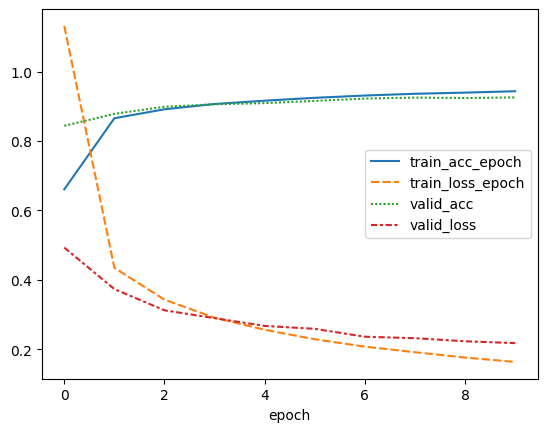

In [40]:
!pip install seaborn
import seaborn as sns

# Set the epoch column as the index, for easier plotting
metrics.set_index("epoch", inplace = True)
metrics.drop(columns = ['step', 'train_loss_step',
                        'train_acc_step', 'test_acc', 'test_loss'], inplace = True)
# Create a line plot of the training metrics using Seaborn
sns.lineplot(data = metrics)

Obtaining last active run id

In [41]:
run_id = mlflow.last_active_run().info.run_id

run_id

'22ae1ed50d724270b87bcc67c4b1fcf6'

Batch of test images are loaded

In [42]:
test_dataiter = iter(test_dataloader)

test_imgs, test_labels = next(test_dataiter)

test_imgs.shape, test_labels.shape

(torch.Size([64, 784]), torch.Size([64]))

Predictions are obtained which are logits

In [44]:
logged_model = f'runs:/{run_id}/emnist-letters-classifier-cnn-model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

predictions = loaded_model.predict(test_imgs.numpy().reshape(-1, 1, 28, 28))

predictions[:5]

KeyboardInterrupt: 

In [ ]:
predictions.shape

(64, 26)

For one instance,Actual label is checked and note that for obtaining class we need to subtract label value by 1

In [ ]:
test_labels[2]

tensor(3.)

In [ ]:
classes = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
           'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

In [ ]:
classes[int(test_labels[2].item())-1]

'c'

predicted label is checked which is same as actual label

In [ ]:
predictions[2]

array([ -2.5369718,  -6.3449926,  16.549416 ,  -3.826386 ,   0.8504368,
        -5.4417667,   2.7831752, -12.054216 ,   0.0612056,  -7.1477184,
        -6.220368 ,   4.2668777, -16.323723 ,  -7.3333797,   1.0002891,
        -4.279484 ,  -3.115275 ,   3.7501683,  -5.205423 ,  -4.3230247,
        -3.4688432,  -6.8734508, -22.878498 ,  -6.6124682,  -9.545356 ,
        -5.455231 ], dtype=float32)

In [ ]:
classes[np.argmax(predictions[2])]

'c'

Defining a function for displaying predicted and actual labels for a batch of images

In [ ]:
def show(idx, title):

    plt.figure()
    plt.imshow(test_imgs.squeeze()[idx].numpy().reshape( 28, 28), cmap = "gray")

    plt.axis("off")
    plt.title("\n\n{}".format(title), fontdict = {"size": 16})

We can observe a batch of images for comparing its predicted label with actual label

In [ ]:
for i in range(64):
    predicted_class = np.argmax(predictions[i])
    actual_class = test_labels[i].long().item()-1

    show(i, "Model prediction {} (class {}), actual category {} (class {})".format(
          classes[predicted_class], predicted_class,
          classes[actual_class], actual_class
    ))

In [45]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_dataloader:
        output = loaded_model.predict(inputs.numpy().reshape(-1, 1, 28, 28)) # Feed Network

        output = np.argmax(output, axis = 1).astype("float64").tolist()
        y_pred.extend(output)

        labels = [ x-1 for x in labels.tolist()]
        y_true.extend(labels)

acc = accuracy_score(y_true, y_pred)
print('Accuracy on test data:', acc)

# Build confusion matrix
cm = confusion_matrix(y_true, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels = classes)

fig, ax = plt.subplots(figsize = (12, 8))
cmp.plot(ax = ax)

NameError: name 'loaded_model' is not defined

Just checking the test accuracy manually which is same as obtained by trainer.test

In [ ]:
np.trace(cm) / len(test_dataset)

0.915399689168187

Defining the search space for hyperparameters using Hyperopt.
we are tuning learning rate, and l1 and l2 which are input and output size for Linear layers coming in deep layers

In [46]:
%pip install hyperopt
from hyperopt import fmin, tpe, hp, Trials

search_space = {
    # Learning rate in log space
    "lr": hp.loguniform("lr", -10, -8),
    "l1": hp.choice("l1", [32, 64, 128]),
    "l2": hp.choice("l2", [64, 128, 256]),
}

  Using cached hyperopt-0.2.7-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached future-1.0.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached py4j-0.10.9.9-py2.py3-none-any.whl.metadata (1.3 kB)
Using cached hyperopt-0.2.7-py2.py3-none-any.whl (1.6 MB)
Using cached future-1.0.0-py3-none-any.whl (491 kB)
Using cached py4j-0.10.9.9-py2.py3-none-any.whl (203 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [hyperopt]2/3 [hyperopt]


Defining the Lightning Module for tuning. Using save_hyperparameters() within your LightningModule’s __init__ method. It will enable Lightning to store all the provided arguments under the self.hparams attribute. These hyperparameters will also be stored within the model checkpoint, which simplifies model re-instantiation after training.

In [47]:
class EmnistModel(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()

        self.save_hyperparameters(hparams)

        self.criterion = nn.CrossEntropyLoss()

        self.network = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #64*14*14

            nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #256*7*7

            nn.Flatten(),
            nn.Linear(256*7*7, self.hparams["l1"]),
            nn.ReLU(),
            nn.Linear(self.hparams["l1"], self.hparams["l2"]),
            nn.ReLU(),
            nn.Linear(self.hparams["l2"], 26)
        )

    def forward(self, xb):
        return self.network(xb.reshape(-1, 1, 28, 28))

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr = self.hparams["lr"])

    def training_step(self, batch, batch_idx):
        x, y = batch
        y -= 1

        y_hat = self(x)
        loss = self.criterion(y_hat, y.long())
        pred = y_hat.argmax(dim = 1)

        acc = accuracy(pred, y, task = "multiclass", num_classes = 26)

        self.log("train_loss", loss, on_epoch = True)
        self.log("train_acc", acc, on_epoch = True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y -= 1

        y_hat = self(x)
        loss = self.criterion(y_hat, y.long())
        pred = y_hat.argmax(dim = 1)

        acc = accuracy(pred, y, task = "multiclass", num_classes = 26)

        self.log("valid_loss", loss, on_epoch = True)
        self.log("valid_acc", acc, on_epoch = True)

        return acc

    def test_step(self, batch, batch_idx):
        x, y = batch
        y -= 1

        y_hat = self(x)
        loss = self.criterion(y_hat, y.long())
        pred = y_hat.argmax(dim = 1)

        acc = accuracy(pred, y, task = "multiclass", num_classes = 26)

        self.log("test_loss", loss)
        self.log("test_acc", acc)

        return acc

    def predict_step(self, batch, batch_idx, dataloader_idx = 0):
        x, y = batch

        return self(x)

Model Training objective is defined with -valid accuracy to be minimised i.e valid accuracy to be maximised. We are also using callback_metrics method from trainer to obtain losses and accuracies and then later on logging them using mlflow. We are also logging model for each run with Model signature same as defined earlier

In [48]:
# Define a function to perform hyperparameter optimization with Hyperopt
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import ColSpec, Schema, TensorSpec

def train_emnist(params):
   with mlflow.start_run(nested = True):

        model = EmnistModel(params)

        trainer = pl.Trainer(max_epochs = 10, accelerator = "gpu")

        trainer.fit(model, train_dataloaders = train_dataloader, val_dataloaders = val_dataloader)

        train_loss = trainer.callback_metrics["train_loss"].item()
        train_acc = trainer.callback_metrics["train_acc"].item()
        valid_loss = trainer.callback_metrics["valid_loss"].item()
        valid_acc = trainer.callback_metrics["valid_acc"].item()

        mlflow.log_params(params)

        mlflow.log_metrics({
            "train_loss_avg": train_loss, "train_acc_avg": train_acc,
            "valid_loss_avg": valid_loss, "valid_acc_avg": valid_acc}
        )

        input_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 1, 28, 28))])
        output_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, 26))])

        signature = ModelSignature(inputs = input_schema, outputs = output_schema)

        mlflow.pytorch.log_model(model, "emnist-letters-classifier-cnn-model", signature = signature)

        return -valid_acc

In [49]:
with mlflow.start_run():
    best_result = fmin(
        fn = train_emnist,
        space = search_space,
        algo = tpe.suggest,
        max_evals = 10,
    )

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/tawate/Documents/DeepLearning_AI_Courses/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

2025/07/16 17:47:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/ta

Sanity Checking: |          | 0/? [00:00<?, ?it/s]    
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

/Users/tawate/Documents/DeepLearning_AI_Courses/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.



  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

/Users/tawate/Documents/DeepLearning_AI_Courses/.venv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.



Training: |          | 0/? [00:00<?, ?it/s]           
Epoch 0: 100%|##########| 1248/1248 [00:42<00:00, 29.25it/s, v_num=0]
Validation: |          | 0/? [00:00<?, ?it/s]         
  0%|          | 0/10 [00:46<?, ?trial/s, best loss=?]

2025/07/16 17:47:58 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Epoch 1: 100%|##########| 1248/1248 [00:42<00:00, 29.41it/s, v_num=0]
Validation: |          | 0/? [00:00<?, ?it/s]         
  0%|          | 0/10 [01:32<?, ?trial/s, best loss=?]

2025/07/16 17:48:44 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Epoch 2: 100%|##########| 1248/1248 [00:42<00:00, 29.31it/s, v_num=0]
Validation: |          | 0/? [00:00<?, ?it/s]         
  0%|          | 0/10 [02:18<?, ?trial/s, best loss=?]

2025/07/16 17:49:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Epoch 3: 100%|##########| 1248/1248 [00:42<00:00, 29.44it/s, v_num=0]
Validation: |          | 0/? [00:00<?, ?it/s]         
  0%|          | 0/10 [03:04<?, ?trial/s, best loss=?]

2025/07/16 17:50:16 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Epoch 4: 100%|##########| 1248/1248 [00:41<00:00, 29.84it/s, v_num=0]
Validation: |          | 0/? [00:00<?, ?it/s]         
  0%|          | 0/10 [03:49<?, ?trial/s, best loss=?]

2025/07/16 17:51:01 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Epoch 5: 100%|##########| 1248/1248 [00:42<00:00, 29.68it/s, v_num=0]
Validation: |          | 0/? [00:00<?, ?it/s]         
  0%|          | 0/10 [04:35<?, ?trial/s, best loss=?]

2025/07/16 17:51:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Epoch 6: 100%|##########| 1248/1248 [00:42<00:00, 29.51it/s, v_num=0]
Validation: |          | 0/? [00:00<?, ?it/s]         
  0%|          | 0/10 [05:20<?, ?trial/s, best loss=?]

2025/07/16 17:52:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Epoch 7: 100%|##########| 1248/1248 [00:42<00:00, 29.06it/s, v_num=0]
Validation: |          | 0/? [00:00<?, ?it/s]         
  0%|          | 0/10 [06:07<?, ?trial/s, best loss=?]

2025/07/16 17:53:19 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Epoch 8: 100%|##########| 1248/1248 [00:42<00:00, 29.63it/s, v_num=0]
Validation: |          | 0/? [00:00<?, ?it/s]         
  0%|          | 0/10 [06:52<?, ?trial/s, best loss=?]

2025/07/16 17:54:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Epoch 9: 100%|##########| 1248/1248 [00:42<00:00, 29.39it/s, v_num=0]
Validation: |          | 0/? [00:00<?, ?it/s]         
  0%|          | 0/10 [07:38<?, ?trial/s, best loss=?]

2025/07/16 17:54:51 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.

`Trainer.fit` stopped: `max_epochs=10` reached.


  0%|          | 0/10 [07:39<?, ?trial/s, best loss=?]

2025/07/16 17:54:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



🏃 View run flawless-swan-31 at: http://127.0.0.1:8080/#/experiments/276748476805243944/runs/e657b205c5384ad6b96902a9c9076a0b

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/276748476805243944

 10%|█         | 1/10 [08:15<1:14:16, 495.15s/trial, best loss: -0.9234148263931274]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | criterion | CrossEntropyLoss | 0      | train
1 | network   | Sequential       | 1.2 M  | train
-------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.786     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]                                  
Sanity Checking DataLoader 0: 100%|##########| 2/2 [00:00<00:00,  5.13it/s]         
Training: |          | 0/? [00:00<?, ?it/s]                                         
Epoch 0: 100%|##########| 1248/1248 [00:42<00:00, 29.13it/s, v_num=1]               
Validation: |          | 0/? [00:00<?, ?it/s]                                       
 10%|█         | 1/10 [09:01<1:14:16, 495.15s/trial, best loss: -0.9234148263931274]

2025/07/16 17:56:13 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Epoch 1: 100%|##########| 1248/1248 [00:42<00:00, 29.57it/s, v_num=1]               
Validation: |          | 0/? [00:00<?, ?it/s]                                       
 10%|█         | 1/10 [09:47<1:14:16, 495.15s/trial, best loss: -0.9234148263931274]

2025/07/16 17:56:59 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Epoch 2: 100%|##########| 1248/1248 [00:41<00:00, 30.07it/s, v_num=1]               
Validation: |          | 0/? [00:00<?, ?it/s]                                       
 10%|█         | 1/10 [10:32<1:14:16, 495.15s/trial, best loss: -0.9234148263931274]

2025/07/16 17:57:44 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Epoch 3: 100%|##########| 1248/1248 [00:41<00:00, 30.18it/s, v_num=1]               
Validation: |          | 0/? [00:00<?, ?it/s]                                       
 10%|█         | 1/10 [11:16<1:14:16, 495.15s/trial, best loss: -0.9234148263931274]

2025/07/16 17:58:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Epoch 4: 100%|##########| 1248/1248 [00:40<00:00, 30.83it/s, v_num=1]               
Validation: |          | 0/? [00:00<?, ?it/s]                                       
 10%|█         | 1/10 [12:00<1:14:16, 495.15s/trial, best loss: -0.9234148263931274]

2025/07/16 17:59:12 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Epoch 5: 100%|##########| 1248/1248 [00:40<00:00, 30.70it/s, v_num=1]               
Validation: |          | 0/? [00:00<?, ?it/s]                                       
 10%|█         | 1/10 [12:44<1:14:16, 495.15s/trial, best loss: -0.9234148263931274]

2025/07/16 17:59:56 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Epoch 6: 100%|##########| 1248/1248 [00:40<00:00, 31.02it/s, v_num=1]               
Validation: |          | 0/? [00:00<?, ?it/s]                                       
 10%|█         | 1/10 [13:27<1:14:16, 495.15s/trial, best loss: -0.9234148263931274]

2025/07/16 18:00:39 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Epoch 7: 100%|##########| 1248/1248 [00:41<00:00, 30.15it/s, v_num=1]               
Validation: |          | 0/? [00:00<?, ?it/s]                                       
 10%|█         | 1/10 [14:12<1:14:16, 495.15s/trial, best loss: -0.9234148263931274]

2025/07/16 18:01:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Epoch 8: 100%|##########| 1248/1248 [00:42<00:00, 29.61it/s, v_num=1]               
Validation: |          | 0/? [00:00<?, ?it/s]                                       
 10%|█         | 1/10 [14:57<1:14:16, 495.15s/trial, best loss: -0.9234148263931274]

2025/07/16 18:02:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Epoch 9: 100%|##########| 1248/1248 [00:41<00:00, 29.83it/s, v_num=1]               
Validation: |          | 0/? [00:00<?, ?it/s]                                       
 10%|█         | 1/10 [15:42<1:14:16, 495.15s/trial, best loss: -0.9234148263931274]

2025/07/16 18:02:54 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.

`Trainer.fit` stopped: `max_epochs=10` reached.


 10%|█         | 1/10 [15:42<1:14:16, 495.15s/trial, best loss: -0.9234148263931274]

2025/07/16 18:02:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



🏃 View run receptive-skunk-500 at: http://127.0.0.1:8080/#/experiments/276748476805243944/runs/e93fe24db30d480bb1deb00c54138bb4

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/276748476805243944       

 20%|██        | 2/10 [15:50<1:02:55, 471.90s/trial, best loss: -0.9335510730743408]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | criterion | CrossEntropyLoss | 0      | train
1 | network   | Sequential       | 2.0 M  | train
-------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.054     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]                                  
Sanity Checking DataLoader 0: 100%|##########| 2/2 [00:00<00:00, 12.68it/s]         
Training: |          | 0/? [00:00<?, ?it/s]                                         
Epoch 0: 100%|##########| 1248/1248 [00:41<00:00, 29.72it/s, v_num=2]               
Validation: |          | 0/? [00:00<?, ?it/s]                                       
 20%|██        | 2/10 [16:36<1:02:55, 471.90s/trial, best loss: -0.9335510730743408]

2025/07/16 18:03:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Epoch 1: 100%|##########| 1248/1248 [00:42<00:00, 29.17it/s, v_num=2]               
Validation: |          | 0/? [00:00<?, ?it/s]                                       
 20%|██        | 2/10 [17:22<1:02:55, 471.90s/trial, best loss: -0.9335510730743408]

2025/07/16 18:04:34 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



Epoch 2: 100%|##########| 1248/1248 [00:51<00:00, 24.10it/s, v_num=2]               
Validation: |          | 0/? [00:00<?, ?it/s]                                       
 20%|██        | 2/10 [18:18<1:02:55, 471.90s/trial, best loss: -0.9335510730743408]

2025/07/16 18:05:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.



 20%|██        | 2/10 [18:26<1:02:55, 471.90s/trial, best loss: -0.9335510730743408]


Detected KeyboardInterrupt, attempting graceful shutdown ...


🏃 View run upset-pug-675 at: http://127.0.0.1:8080/#/experiments/276748476805243944/runs/14025c21b3f94dfbae7fbdd579b7d2ec

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/276748476805243944       

 20%|██        | 2/10 [18:26<1:02:55, 471.90s/trial, best loss: -0.9335510730743408]

ERROR:hyperopt.fmin:job exception: name 'exit' is not defined


 20%|██        | 2/10 [18:26<1:13:44, 553.11s/trial, best loss: -0.9335510730743408]
🏃 View run smiling-lark-495 at: http://127.0.0.1:8080/#/experiments/276748476805243944/runs/ca10b5d3fa6a4e6bb592915b98bb2af0
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/276748476805243944


NameError: name 'exit' is not defined

### TODO Recording:

- As the hyperparameter tuning is running go to the MLflow UI
- Select the current experiment
- Show that the outer run appears with a +, expand and show the inner run
- Click on the + next to the metrics and add test_acc, train_acc, valid_acc
- Stay on the page and hit refresh till 2-3 runs complete
- Click through to a run and show the metrics there
- Come back to the main experiments page and click on refresh
- Click on Chart and hide all EXCEPT 2 runs
- Show how we can compare those two runs in the charts - show all the charts with this comparison


Best set of parameters are obatined

In [ ]:
best_result

{'l1': 2, 'l2': 2, 'lr': 0.00029037728885191675}

In [ ]:
import hyperopt

print(hyperopt.space_eval(search_space, best_result))

{'l1': 128, 'l2': 256, 'lr': 0.00029037728885191675}


### TODO Recording:

- Go to the MLflow UI
- Sort the runs by valid_acc (should be a column on the experiments page, we added it earlier)
- Sort in descending order
- Find the model with the best validation accuracy
- Click through and show the parameters of the model
- Select the model directory under artifacts
- Copy over the run ID for predictions


In [ ]:
import mlflow
logged_model = 'runs:/c8a26cab055a43029ee56fdeb7c9dc8c/emnist-letters-classifier-cnn-model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame

predictions = loaded_model.predict(test_imgs.numpy().reshape(-1, 1, 28, 28))

predictions[:5]

array([[ -5.168775  ,  -7.849242  ,  11.979329  ,  -9.365232  ,
         -1.6717076 , -11.296753  ,   0.11165346,  -8.794175  ,
         -8.275728  , -10.553259  ,  -6.163144  ,  -2.2958124 ,
        -19.072134  ,  -9.198095  ,  -4.3010516 , -15.353595  ,
         -8.307044  ,  -2.6906972 ,  -3.0173972 ,  -7.9163074 ,
         -2.9328923 ,  -3.7120683 , -13.3012495 , -16.394533  ,
        -10.962013  , -15.603565  ],
       [-13.25938   , -16.394947  , -21.061014  ,  -1.4416673 ,
        -20.79775   , -16.974648  ,  -7.767819  ,  -9.47629   ,
         -6.921515  ,   6.396232  , -21.787628  , -14.321276  ,
        -17.314238  ,  -6.419229  , -15.739896  , -16.113024  ,
        -13.859051  ,  -4.9486475 ,  -6.9380517 ,  -4.180274  ,
        -12.419431  ,  -3.1710205 , -12.257841  , -12.100891  ,
        -13.190232  , -16.223484  ],
       [ -7.4829836 , -11.913907  ,  12.870435  ,  -6.283403  ,
         -5.019596  ,  -6.5086837 ,  -3.354376  , -11.650033  ,
        -11.02249   , -18.3632

array([[ -5.168775  ,  -7.849242  ,  11.979329  ,  -9.365232  ,
         -1.6717076 , -11.296753  ,   0.11165346,  -8.794175  ,
         -8.275728  , -10.553259  ,  -6.163144  ,  -2.2958124 ,
        -19.072134  ,  -9.198095  ,  -4.3010516 , -15.353595  ,
         -8.307044  ,  -2.6906972 ,  -3.0173972 ,  -7.9163074 ,
         -2.9328923 ,  -3.7120683 , -13.3012495 , -16.394533  ,
        -10.962013  , -15.603565  ],
       [-13.25938   , -16.394947  , -21.061014  ,  -1.4416673 ,
        -20.79775   , -16.974648  ,  -7.767819  ,  -9.47629   ,
         -6.921515  ,   6.396232  , -21.787628  , -14.321276  ,
        -17.314238  ,  -6.419229  , -15.739896  , -16.113024  ,
        -13.859051  ,  -4.9486475 ,  -6.9380517 ,  -4.180274  ,
        -12.419431  ,  -3.1710205 , -12.257841  , -12.100891  ,
        -13.190232  , -16.223484  ],
       [ -7.4829836 , -11.913907  ,  12.870435  ,  -6.283403  ,
         -5.019596  ,  -6.5086837 ,  -3.354376  , -11.650033  ,
        -11.02249   , -18.3632

For whole test data, predictions are obtained and accuracy is checked which is bit higher than untuned model

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_dataloader:
        output = loaded_model.predict(inputs.numpy().reshape(-1, 1, 28, 28)) # Feed Network

        output = np.argmax(output, axis = 1).astype('float64').tolist()
        y_pred.extend(output)

        labels = [ x-1 for x in labels.tolist()]
        y_true.extend(labels)

acc = accuracy_score(y_true, y_pred)
print('Accuracy on test data:', acc)

Accuracy on test data: 0.9233056287586999


### TODO Recording:

- Go back to the MLflow UI - where you should have the page for the best model open
- Select the artifacts directory and "Register this model"
- Model name: emnist_cnn_classification
- Go to the Models tab in the UI
- Show version 1 of the model is registered
- Click through and show the model
- Change the Stage of the model to "Staging"
- Change the Stage of the model to "Production"

